# Preprocessing & EDA

## Preparations

modules

In [1]:
import os  # interacting with the operating system
import pandas as pd  # working with dataframes
import numpy as np  # simple functions for vectors and matrices
import matplotlib.pyplot as plt  # simple plotting
from helper_functions import (transform_to_timestamp, 
                              extract_closest_hour) # own functions

options

In [2]:
# automatic reloading of modules and functions before each cell
%load_ext autoreload
%autoreload 2

In [3]:
# plotting
%matplotlib inline
plt.style.use(['dark_background'])
plt.rc('figure', figsize=(20.0, 10.0))

In [4]:
# create dedicated folders for saving results if not yet existing
for folder in ['data', 'plots']:
    if not os.path.exists(folder):
        os.makedirs(folder)

loading data

In [5]:
df = pd.read_csv('data/vienna_scooter_positions.csv', index_col=0)

## Preprocessing

In [6]:
df.shape

(869641, 4)

Our data holds almost 900,000 observations with 4 variables.

In [7]:
df.head()

,id,lat,lon,time
0,EMTRPL,48.184833,16.416045,04:59:57
1,RSPUIN,48.220575,16.356078,04:59:57
2,LHCMAF,48.193983,16.399211,04:59:57
3,JZKAIQ,48.202690,16.393311,04:59:57
4,WHLPTK,48.226330,16.352546,04:59:57


The information we can use seems to be the following:
- an anonymized id per scooter
- a timestamp down to the second
- the longitude and latitude coordinates for that particular timestamp

Let's see how many unique scooters we have in our sample.

In [8]:
print('Our sample holds %s unique scooters.'%len(df.id.drop_duplicates()))

Our sample holds 997 unique scooters.


In [9]:
df.dtypes

id       object
lat     float64
lon     float64
time     object
dtype: object

In [10]:
df.time[0]

'04:59:57'

We need to transform the time column from a string value into a timestamp before we can further use it for our analysis. We therefore use one of our predefined functions from `helper_functions.py`.

In [11]:
df['time'] = df.time.map(transform_to_timestamp)

In [12]:
df.time[0]

datetime.time(4, 59, 57)

## EDA

It is time to focus on collecting intel about our dataset and answer questions like: How do the distributions per scooter and timestamp look like?

To begin we create a dataframe on user level where we collect alltime information for each scooter, e.g. how many observations do we have.

In [13]:
df_scooter_level = df.id.value_counts().to_frame(name='n_seen')

In [14]:
print(df_scooter_level[:5])
print(df_scooter_level[-5:])

        n_seen
FPWXUQ     911
NLMWIG     911
ALUIQD     911
RNUSIE     911
JHQBFL     911
        n_seen
XMYZOP     260
APUJCG     156
HMVWTO     108
YUDGAM      17
LHCDGF       2


In [15]:
len(df_scooter_level[df_scooter_level.n_seen==911])

25

The scooters have a wide range of observation counts. One is only seen as few as two times, on the other hand 25 scooters account for 911 observations each during that day. If each of these observations would be a different user/usage that would mean a new user every minute for those scooters. Timestamps range from 5 AM to a bit later than 9 PM, which means 16 hours or 960 minutes inside the time frame. As we lack the domain knowledge here if each new timestamp represents a new booking or user we need do dive deeper, checking out the coordinate changes.

In [16]:
df[df.id == df_scooter_level.index[0]].head(10)

,id,lat,lon,time
465,FPWXUQ,48.218206,16.393448,04:59:57
1152,FPWXUQ,48.218206,16.393448,05:00:59
1576,FPWXUQ,48.218206,16.393448,05:02:02
2222,FPWXUQ,48.218206,16.393448,05:03:05
3170,FPWXUQ,48.218206,16.393448,05:04:07
3953,FPWXUQ,48.218206,16.393448,05:05:10
4258,FPWXUQ,48.218206,16.393448,05:06:13
5212,FPWXUQ,48.218206,16.393448,05:07:16
5681,FPWXUQ,48.218206,16.393448,05:08:18
6366,FPWXUQ,48.218206,16.393448,05:09:21


Since the coordinates are precise down to the 6th decimal, we can be quite sure it does not change location. Also see https://en.wikipedia.org/wiki/Decimal_degrees for this. Additionally we can see a *pinging* pattern every 62-63 seconds. So what is happening with the low frequency scooters?

In [17]:
df[df.id == 'LHCDGF']

,id,lat,lon,time
44964,LHCDGF,48.191268,16.379278,05:57:29
45951,LHCDGF,48.191268,16.379278,05:58:32


First of all: **same pinging interval**, but solely once. We conclude that each ping does **not** signify a new rent action but the scooters just differ in when they are actively pinging. In order to identify a new usage we will focus on a change in coordinates as they are very granular.

Therefore we define **unique_locations** as unique observations of exact locations. 

(Note: this is a simplification, as a scooter could be brought back to the exact same position, which we consider unlikely for now.)

In [18]:
unique_locs = df.drop('time', axis=1).drop_duplicates().groupby('id')\
                .size().to_frame(name='unique_locs')

In [19]:
unique_locs.head()

,unique_locs
id,
ABKIFV,60
ACODMP,146
ADIBPW,33
ADKPIH,46
ADULSM,44


In [20]:
np.median(unique_locs)

50.0

On average each scooter is at 50 different unique locations. Let's join it onto our alltime dataframe using the scooter id as index and plot its distribution.

In [21]:
df_scooter_level = df_scooter_level.merge(unique_locs, how='left',
                                          left_index=True, 
                                          right_index=True).fillna(0)

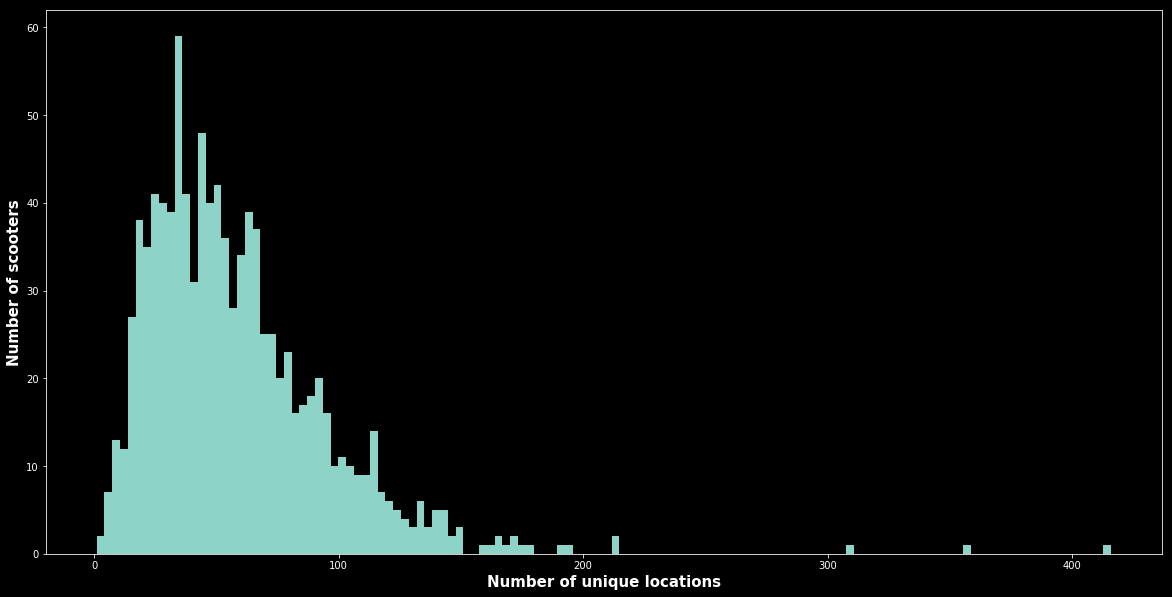

In [22]:
plt.hist(df_scooter_level.unique_locs, bins=130)
plt.xlabel('Number of unique locations', fontsize = 15, fontweight='semibold')
plt.ylabel('Number of scooters', fontsize = 15, fontweight='semibold')
plt.savefig('plots/unique_locs_dist.png')
plt.show()

The number of different locations of scooters show a right-skewed distribution with a long right tail. That means there are a couple of scooters which are being used heavily compared to the median of 50 per day. It does make sense to look at where these heavily used scooters are being located inside the city. Also it seems we have a couple of scooters with no change in location, i.e. not being used even once.

In [23]:
not_used = list(df_scooter_level[df_scooter_level.unique_locs==1].index)
print(not_used)

['VFQJBR', 'LHCDGF']


Two scooters have not changed location during the day at all. Under the assumption our sample represents a typical day, we want to redistribute these scooters with the highest urgency. This leads us to our **first main finding**.

Next we want to have a look at the distribution of uses over the day. Therefore we need to identify the last timestamp before a location change and save that into a dataframe on usage level.

In [24]:
df_usage_level = df.sort_values(['id', 'lat', 'lon'])\
                   .groupby(['id', 'lat', 'lon']).last()

We also extract the hour of the rent begin and aggregate per hour of the day.

In [25]:
df_usage_level['hour'] = df_usage_level.time.map(extract_closest_hour)
hour_of_day = df_usage_level.groupby('hour').size()

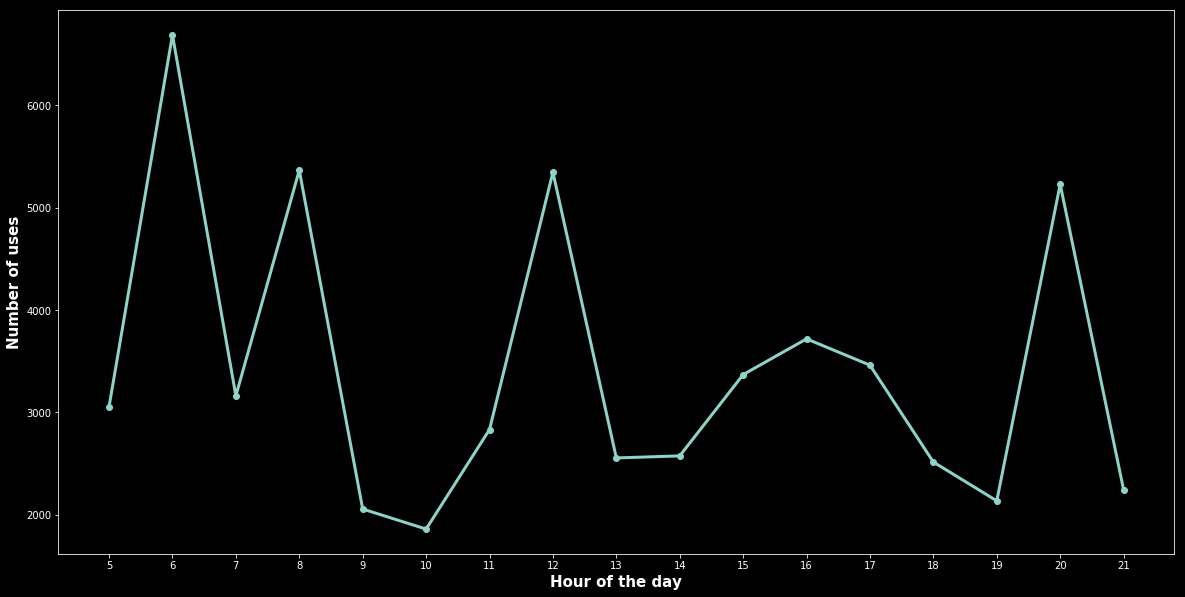

In [26]:
plt.plot(list(hour_of_day.index), hour_of_day, marker='o', lw=3)
plt.xlabel('Hour of the day', fontsize = 15, fontweight='semibold')
plt.ylabel('Number of uses', fontsize = 15, fontweight='semibold')
plt.xticks(ticks=list(hour_of_day.index))
plt.savefig('plots/during_day_dist.png')
plt.show()

We can definitely identify peaks of higher usage, the highest being around 6 AM in the morning, maybe relocation, maybe rush hour. It is important that the scooters are being distributed optimally **before** that peak if it actually signifies uses. Other interesting peaks are around 8 AM, 11 AM to 12 PM and around 8 PM in the evening. Additionally there are also times of low frequency during working hours which might be suitable for smaller reallocations by the operations team during the day. This signifies our **second main finding**. Also we want to focus our relocation on the locations which are heavily frequented between 5 AM and 8:30 AM.

## Saving results

Before we move on to groundtruthing the scooter locations inside Vienna we want to save our current findings.

In [27]:
df_scooter_level.to_csv('data/scooter_level.csv')